In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_visuals as dv
import database as db
import rating_predictor as rp
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from scipy.stats import linregress

# Data Histogram

In [240]:
apba = db.load_all_apba()



apba['D'] = apba[['RateCDefence', "RateLWDefense", "RateRwDefence", 'RateLDDefence', "RateRDDefence"]].max(axis=1)

abpa = apba[apba['D'] > 0]
#
apba


,Last,First,year,RateAssist,RateCDefence,RateClearing,RateCoincidentalMinor,RateCRank,RateCShotPct,RateCShotPlus,...,RateRWShotPct,RateRWShotPlus,RateSDefence,RateShiftFatigue,RateShotBlocking,RateSkating,RateSpeed,RateSShotPct,RateSShotPlus,D
0,Aho,Sebastian,19,126,4,0,0,1,25,43,...,0,0,0,90,0,5,5,25,43,4
1,Jos. Anderson,Josh,19,44,0,0,0,NaN,0,0,...,23,53,0,90,0,4,4,23,53,5
2,Jo. Bailey,Josh,19,165,0,0,1,NaN,0,0,...,25,33,0,90,0,4,3,25,33,3
3,Barkov,Aleksander,19,112,4,0,1,1,34,59,...,0,0,0,90,0,4,4,34,59,4
4,Barzal,Mathew,19,153,2,0,1,1,20,28,...,0,0,0,90,0,5,5,20,28,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8498,Omark,Linus,14,51,0,0,1,NaN,0,0,...,0,0,0,90,0,3,3,0,3,1
8499,C.Brown,Chris,14,74,1,0,1,3.0,25,33,...,25,33,0,90,0,2,3,25,33,1
8500,Vanek,Thomas,14,139,0,0,1,NaN,0,0,...,22,36,0,90,0,3,3,22,36,2
8501,Moulson,Matt,14,97,0,0,1,NaN,0,0,...,0,0,0,90,0,3,3,26,38,3


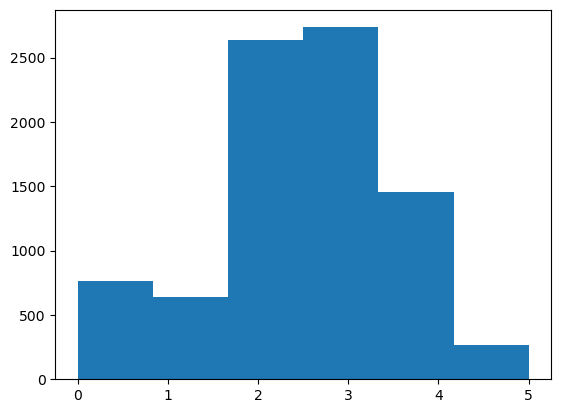

In [241]:
dv.data_histogram(apba, 'D', 6)

In [242]:
# dv.data_histogram(apba, 'F', 6)

# Stat analysis

How to define defence
We propose the following metrics:
1. DzStart %
2. GA/60
3. Hits
4. xGA/60
5. CorsiAgainst/60
6. FenwickAgainst/60

One Key element that should be obvious is the need to seperate forward from defence.


In [243]:
real_data = db.load_hr(['14-15', '15-16', '16-17', '17-18', '18-19', '19-20', '20-21', '21-22', '22-23'])
real_data.head()

real_data.columns

Index(['Player', 'Age', 'Tm', 'Pos', 'GP', 'G', 'A', 'PTS', 'PlusMin', 'PIM',
       'PS', 'G-EV', 'G-PP', 'G-SH', 'G-GW', 'A-EV', 'A-PP', 'A-SH', 'SOG',
       'ShotPerc', 'TOI', 'ATOI', 'BLK', 'HIT', 'FOW', 'FOL', 'FOPerc', 'UID',
       'season', 'CorsiFor', 'CorsiAgainst', 'CorsiForPerc', 'CorsiForPercRel',
       'FenwickF', 'FenwickA', 'FenwickPerc', 'FenwickPercRel',
       'TeamOnIceShootPerc', 'TeamOnIceSavePerc', 'ShootPercPlusSavePerc',
       'OZoneStartPerc', 'DZoneStartPerc', 'ATOIEV', 'TakeAways', 'GiveAways',
       'EPlusMin', 'ShotAttempts', 'ShotThruPerc', 'GoalsCreated', 'GPerGame',
       'APerGame', 'PtsPerGame', 'GoalsCreatedPerGame', 'SOGPerGameAdjusted',
       'GAdjusted', 'AAdjusted', 'PtsAdjusted', 'GCAdjusted', 'TotGF',
       'TotPPGF', 'TotGA', 'TotPPGA', 'XGF', 'XGA', 'XPlusMin', 'OPS', 'DPS',
       'TotPS', 'ShootoutMiss', 'ShiftLength', 'CorsiForRelES', 'GFPer60',
       'GAPer60', 'ATOIPP', 'PPCorsiPercRel', 'PPGFPer60', 'PPGAPer60',
       'ATOISH',

In [244]:
small = real_data.filter(items=['Player', 'season', 'Pos', 'GP', 'ATOI', 'BLK',
                                'CorsiForPerc', 'FenwickPerc',
                        'CorsiForPercRel', 'FenwickPercRel', 'CorsiAgainst',
                        'DZoneStartPerc', 'EPlusMinus', 'GAPer60', 'XGA', 'XGF', 'GFPer60'])

small

,Player,season,Pos,GP,ATOI,BLK,CorsiForPerc,FenwickPerc,CorsiForPercRel,FenwickPercRel,CorsiAgainst,DZoneStartPerc,GAPer60,XGA,XGF,GFPer60
0,Justin Abdelkader,14-15,LW,71,17:55,28.0,56.4,55.3,4.0,4.1,704,36.4,2.3,29.3,39.1,2.9
1,Will Acton,14-15,C,3,10:43,3.0,44.7,53.3,-9.8,1.9,26,89.5,6.4,0.7,0.5,2.1
2,Luke Adam,14-15,C,3,6:27,0.0,55.0,38.5,8.7,-8.0,9,70.0,0.0,0.8,0.1,0.0
3,Craig Adams,14-15,RW,70,9:45,29.0,47.8,47.9,-6.3,-6.6,396,50.0,1.6,18.0,14.6,1.3
4,Andrew Agozzino,14-15,LW,1,9:45,0.0,36.4,43.8,-11.8,-4.4,14,50.0,0.0,0.3,0.4,6.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8208,Mika Zibanejad,22-23,C,82,19:58,48.0,51.4,52.3,1.9,2.6,1064,51.5,2.1,49.4,51.0,3.3
8209,Radim Zohorna,22-23,F,10,8:35,2.0,53.2,52.4,-1.8,-2.6,65,51.7,4.8,4.3,3.8,2.9
8210,Artem Zub,22-23,D,53,20:15,67.0,49.9,51.2,-3.0,-2.1,895,55.2,2.4,39.0,38.1,2.4
8211,Mats Zuccarello,22-23,LW,78,20:12,51.0,53.0,53.3,4.8,4.5,1145,35.1,2.7,48.0,52.7,2.6


In [245]:
def convert_time(atoi: str) -> int:
    """ Converts a string represnetation of time on ice to
    a float representation of time on ice in minutes.

    params:
        atoi: string representation of time on ice in the format
        'MM:SS'
    returns:
        int representation of time on ice in seconds.
    """

    times = atoi.split(':')
    return int(times[0]) * 60 + int(times[1])
small['ATOI'] = small.apply(lambda x: convert_time(x['ATOI']), axis=1)

In [246]:
small['exGA_60'] = small['XGA'] / small['GP'] / small['ATOI'] * 3600
small['exGF60'] = small['XGF'] / small['GP'] / small['ATOI'] * 3600
small['BLK_60'] = small['BLK'] / small['GP'] / small['ATOI'] * 3600
small['CorsiAgainst_60'] = small['CorsiAgainst'] / small['GP'] / small['ATOI'] * 3600
small

,Player,season,Pos,GP,ATOI,BLK,CorsiForPerc,FenwickPerc,CorsiForPercRel,FenwickPercRel,CorsiAgainst,DZoneStartPerc,GAPer60,XGA,XGF,GFPer60,exGA_60,exGF60,BLK_60,CorsiAgainst_60
0,Justin Abdelkader,14-15,LW,71,1075,28.0,56.4,55.3,4.0,4.1,704,36.4,2.3,29.3,39.1,2.9,1.381985,1.844219,1.320668,33.205372
1,Will Acton,14-15,C,3,643,3.0,44.7,53.3,-9.8,1.9,26,89.5,6.4,0.7,0.5,2.1,1.306376,0.933126,5.598756,48.522551
2,Luke Adam,14-15,C,3,387,0.0,55.0,38.5,8.7,-8.0,9,70.0,0.0,0.8,0.1,0.0,2.480620,0.310078,0.000000,27.906977
3,Craig Adams,14-15,RW,70,585,29.0,47.8,47.9,-6.3,-6.6,396,50.0,1.6,18.0,14.6,1.3,1.582418,1.283516,2.549451,34.813187
4,Andrew Agozzino,14-15,LW,1,585,0.0,36.4,43.8,-11.8,-4.4,14,50.0,0.0,0.3,0.4,6.2,1.846154,2.461538,0.000000,86.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8208,Mika Zibanejad,22-23,C,82,1198,48.0,51.4,52.3,1.9,2.6,1064,51.5,2.1,49.4,51.0,3.3,1.810334,1.868969,1.759029,38.991816
8209,Radim Zohorna,22-23,F,10,515,2.0,53.2,52.4,-1.8,-2.6,65,51.7,4.8,4.3,3.8,2.9,3.005825,2.656311,1.398058,45.436893
8210,Artem Zub,22-23,D,53,1215,67.0,49.9,51.2,-3.0,-2.1,895,55.2,2.4,39.0,38.1,2.4,2.180294,2.129979,3.745632,50.034941
8211,Mats Zuccarello,22-23,LW,78,1212,51.0,53.0,53.3,4.8,4.5,1145,35.1,2.7,48.0,52.7,2.6,1.827875,2.006855,1.942117,43.602437


How does corsi, exGA and fenwick correlate with GA/60

In [247]:
small['CorsiAgainst_60'].describe()

count    8213.000000
mean       48.948849
std         8.602767
min         0.000000
25%        44.152711
50%        48.009016
75%        52.406070
max       160.714286
Name: CorsiAgainst_60, dtype: float64

In [248]:
colors = {'D': 'red', 'F': 'blue', 'LW': 'blue', 'RW': 'blue', 'C': 'blue', 'W': 'blue'}

In [249]:
small = small[small['GP'] > 20]


In [250]:
forwards = small[small['Pos'].isin(['C', 'LW', 'RW', 'W'])]
defence = small[small['Pos'].isin(['D'])]

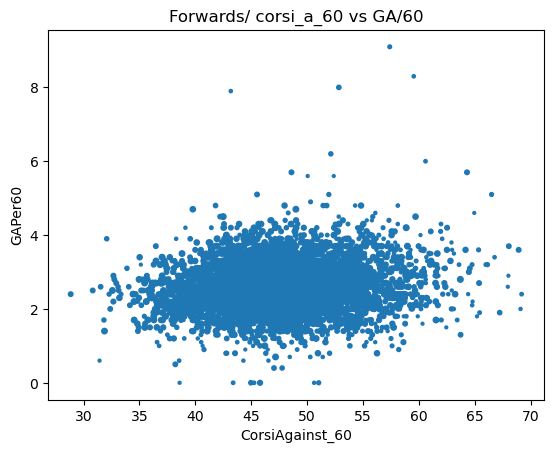

In [251]:
plt.scatter(small['CorsiAgainst_60'], small['GAPer60'], s=small['GP'] / 5)
plt.xlabel('CorsiAgainst_60')
plt.ylabel('GAPer60')
plt.title('Forwards/ corsi_a_60 vs GA/60')
plt.show()

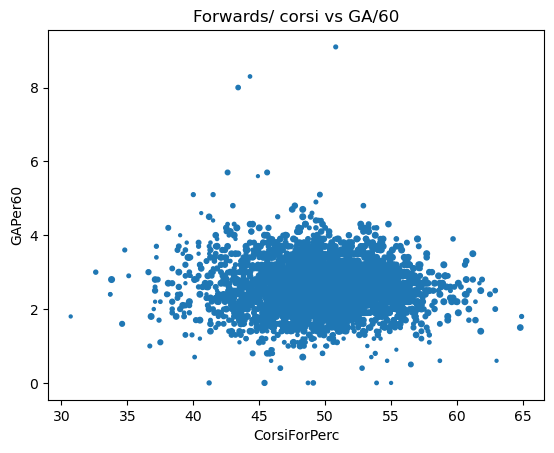

In [252]:
plt.scatter(forwards['CorsiForPerc'], forwards['GAPer60'], s=forwards['GP'] / 5)
plt.xlabel('CorsiForPerc')
plt.ylabel('GAPer60')
plt.title('Forwards/ corsi vs GA/60')
plt.show()


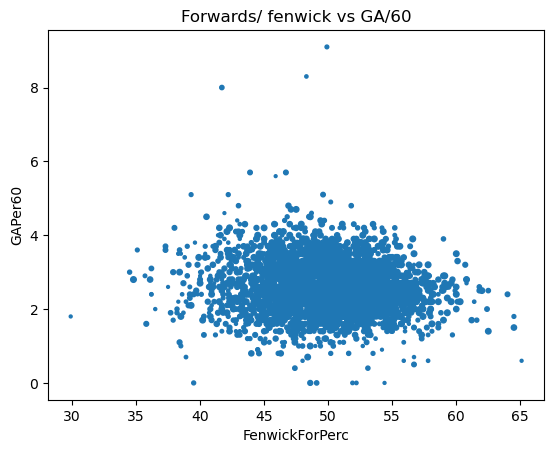

In [253]:
plt.scatter(forwards['FenwickPerc'], forwards['GAPer60'], s=forwards['GP'] / 5)
plt.xlabel('FenwickForPerc')
plt.ylabel('GAPer60')
plt.title('Forwards/ fenwick vs GA/60')
plt.show()

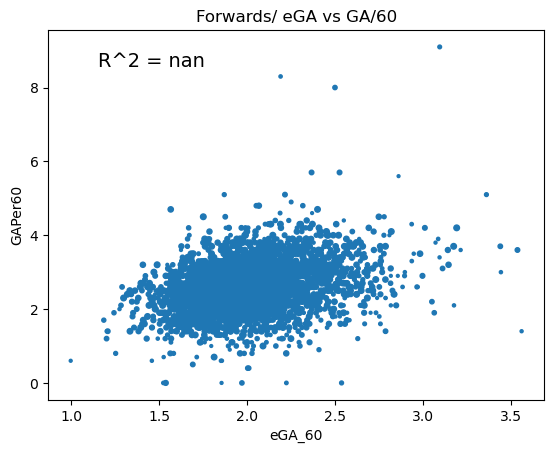

In [254]:

plt.scatter(forwards['exGA_60'], forwards['GAPer60'], s=forwards['GP'] / 5)

slope, intercept = np.polyfit(forwards['exGA_60'], forwards['GAPer60'], 1)
line_of_best_fit = slope * forwards['exGA_60'] + intercept
plt.plot(forwards['exGA_60'], line_of_best_fit, 'r', label='y={:.2f}x+{:.2f}'.format(slope, intercept))

slope, intercept, r_value, p_value, std_err = linregress(forwards['exGA_60'], forwards['GAPer60'])
r_squared = r_value ** 2

plt.text(0.1, 0.9, f'R^2 = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=14)

plt.xlabel('eGA_60')
plt.ylabel('GAPer60')
plt.title('Forwards/ eGA vs GA/60')
plt.show()

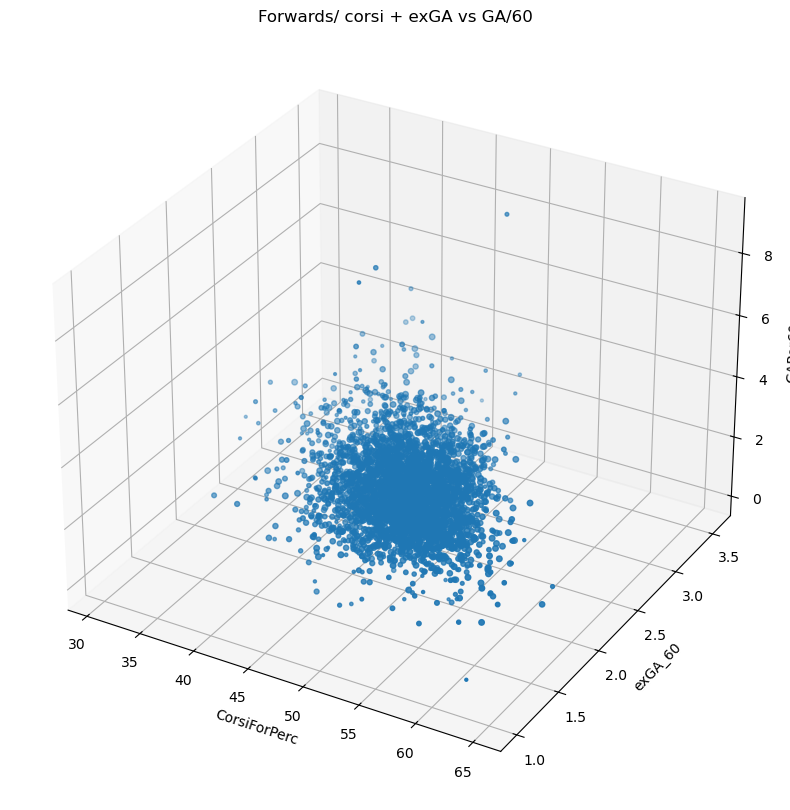

In [255]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(forwards['CorsiForPerc'], forwards['exGA_60'], forwards['GAPer60'], s=forwards['GP'] / 5)

ax.set_xlabel('CorsiForPerc')
ax.set_ylabel('exGA_60')
ax.set_zlabel('GAPer60')

ax.set_title('Forwards/ corsi + exGA vs GA/60')
plt.show()

In [256]:
fig = px.scatter_3d(forwards, x='CorsiForPerc', y='exGA_60', z='GAPer60', size='GP', opacity=0.7, title='Forwards/ corsi + exGA vs GA/60')
fig.show()

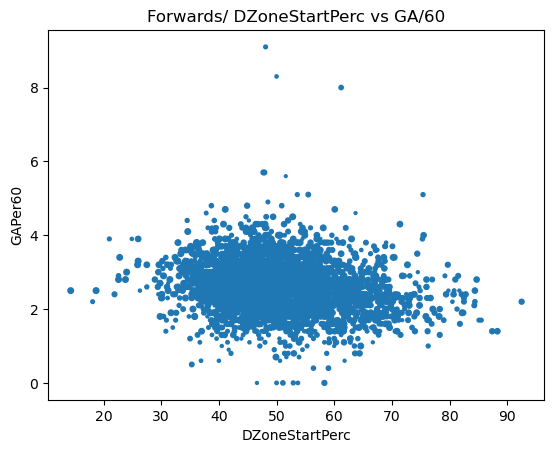

In [257]:
plt.scatter(forwards['DZoneStartPerc'], forwards['GAPer60'], s=forwards['GP'] / 5)
plt.xlabel('DZoneStartPerc')
plt.ylabel('GAPer60')
plt.title('Forwards/ DZoneStartPerc vs GA/60')
plt.show()

Text(0.5, 1.0, 'Defence/ corsi vs GA/60')

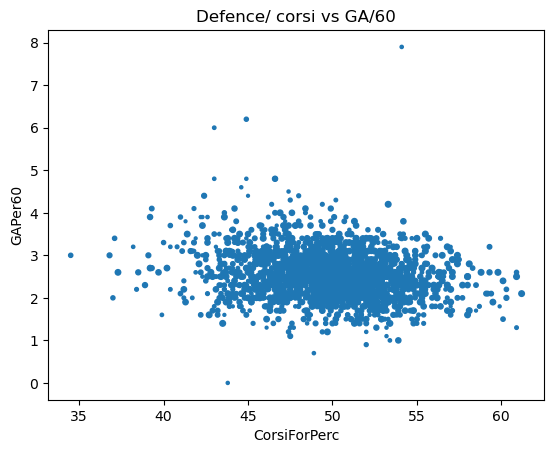

In [258]:
plt.scatter(defence['CorsiForPerc'], defence['GAPer60'], s=defence['GP'] / 5)
plt.xlabel('CorsiForPerc')
plt.ylabel('GAPer60')
plt.title('Defence/ corsi vs GA/60')

Text(0.5, 1.0, 'Defence/ fenwick vs GA/60')

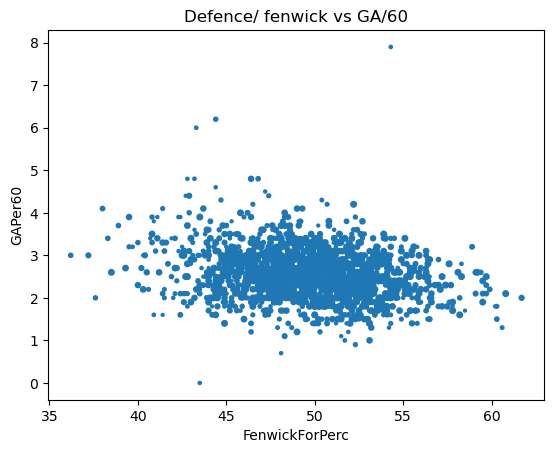

In [259]:
plt.scatter(defence['FenwickPerc'], defence['GAPer60'], s=defence['GP'] / 5)
plt.xlabel('FenwickForPerc')
plt.ylabel('GAPer60')
plt.title('Defence/ fenwick vs GA/60')

Text(0.5, 1.0, 'Defence/ eGA vs GA/60')

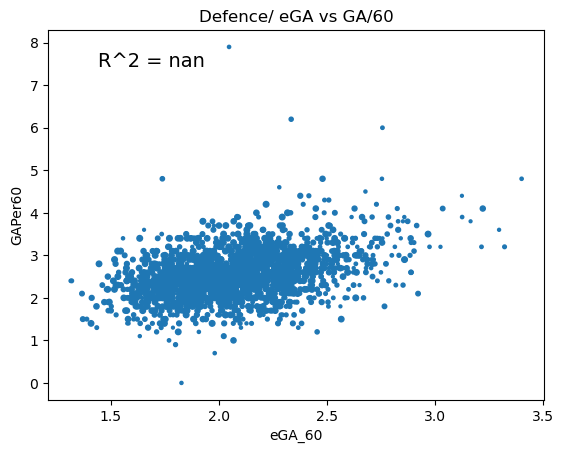

In [260]:
plt.scatter(defence['exGA_60'], defence['GAPer60'], s=defence['GP'] / 5)

slope, intercept = np.polyfit(defence['exGA_60'], defence['GAPer60'], 1)
line_of_best_fit = slope * defence['exGA_60'] + intercept
plt.plot(defence['exGA_60'], line_of_best_fit, 'r', label='y={:.2f}x+{:.2f}'.format(slope, intercept))

slope, intercept, r_value, p_value, std_err = linregress(defence['exGA_60'], defence['GAPer60'])
r_squared = r_value ** 2

plt.text(0.1, 0.9, f'R^2 = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=14)

plt.xlabel('eGA_60')
plt.ylabel('GAPer60')
plt.title('Defence/ eGA vs GA/60')

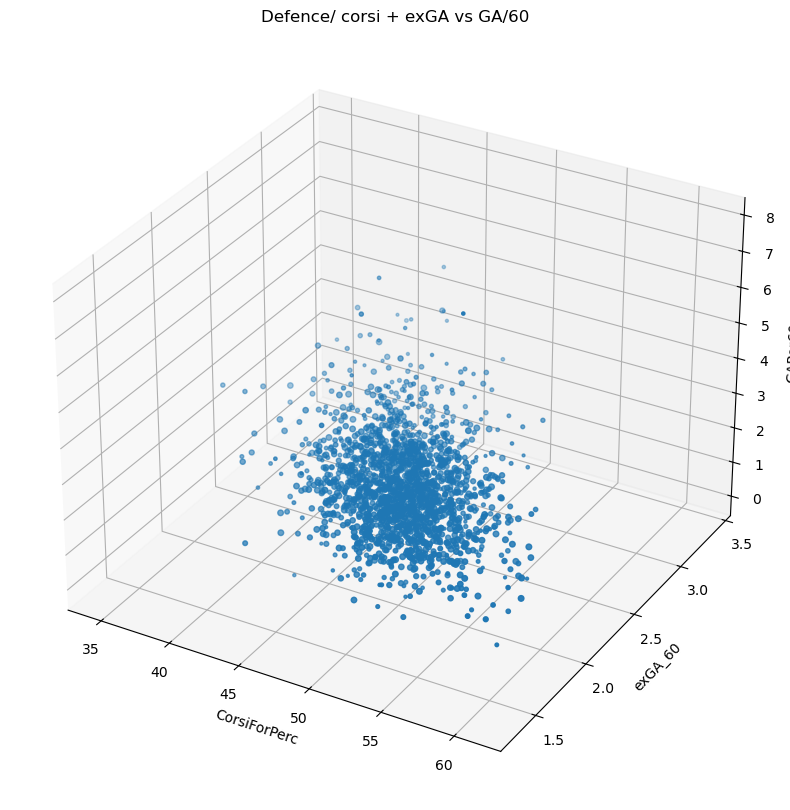

In [261]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(defence['CorsiForPerc'], defence['exGA_60'], defence['GAPer60'], s=defence['GP'] / 5)


ax.set_xlabel('CorsiForPerc')
ax.set_ylabel('exGA_60')
ax.set_zlabel('GAPer60')

ax.set_title('Defence/ corsi + exGA vs GA/60')
plt.show()

In [262]:
fig = px.scatter_3d(defence, x='CorsiForPerc', y='exGA_60', z='GAPer60', size='GP', opacity=0.7, title='Defence/ corsi + exGA vs GA/60')
fig.show()

Text(0.5, 1.0, 'Defence/ DZoneStartPerc vs GA/60')

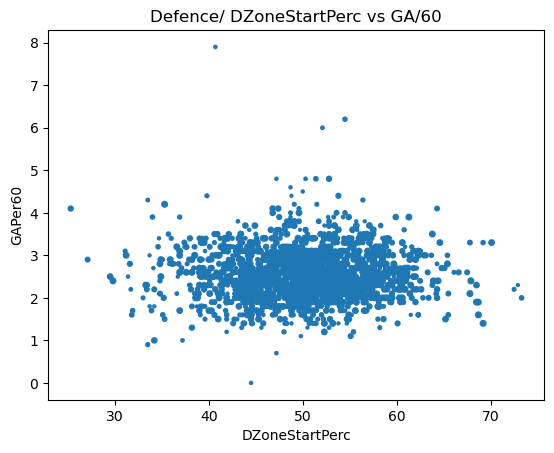

In [263]:
plt.scatter(defence['DZoneStartPerc'], defence['GAPer60'], s=defence['GP'] / 5)
plt.xlabel('DZoneStartPerc')
plt.ylabel('GAPer60')
plt.title('Defence/ DZoneStartPerc vs GA/60')

Text(0.5, 1.0, 'Defence/ BLK vs GA/60')

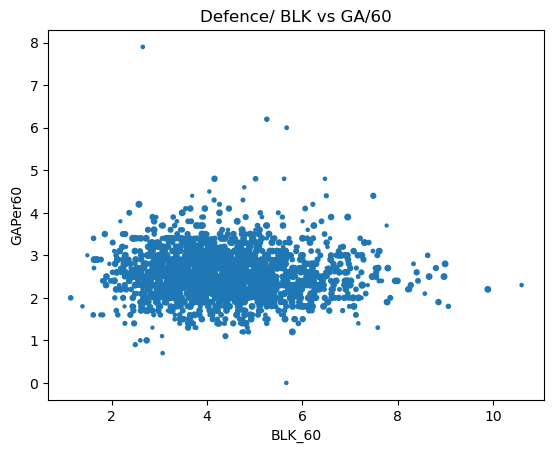

In [264]:
plt.scatter(defence['BLK_60'], defence['GAPer60'], s=defence['GP'] / 5)
plt.xlabel('BLK_60')
plt.ylabel('GAPer60')
plt.title('Defence/ BLK vs GA/60')

Text(0.5, 1.0, 'Defence/ BLK vs GA/60')

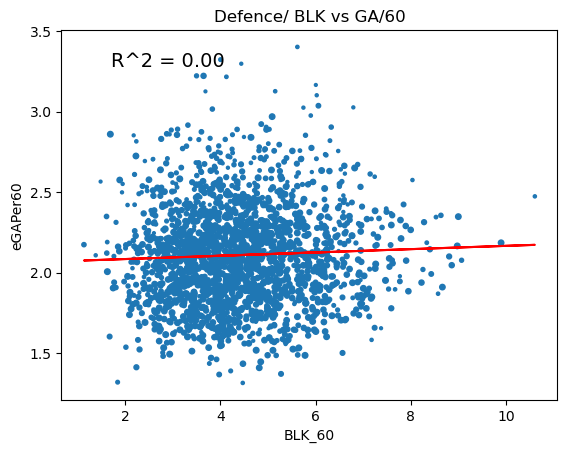

In [265]:

plt.scatter(defence['BLK_60'], defence['exGA_60'], s=defence['GP'] / 5)

slope, intercept = np.polyfit(defence['BLK_60'], defence['exGA_60'], 1)
line_of_best_fit = slope * defence['BLK_60'] + intercept
plt.plot(defence['BLK_60'], line_of_best_fit, 'r', label='y={:.2f}x+{:.2f}'.format(slope, intercept))

slope, intercept, r_value, p_value, std_err = linregress(defence['BLK_60'], defence['exGA_60'])

r_squared = r_value ** 2

plt.text(0.1, 0.9, f'R^2 = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=14)
plt.xlabel('BLK_60')
plt.ylabel('eGAPer60')
plt.title('Defence/ BLK vs GA/60')

# Now we can compare the stats to previous ratings collecting r^2 scores for each stat.

In [266]:
small.head()

,Player,season,Pos,GP,ATOI,BLK,CorsiForPerc,FenwickPerc,CorsiForPercRel,FenwickPercRel,CorsiAgainst,DZoneStartPerc,GAPer60,XGA,XGF,GFPer60,exGA_60,exGF60,BLK_60,CorsiAgainst_60
0,Justin Abdelkader,14-15,LW,71,1075,28.0,56.4,55.3,4.0,4.1,704,36.4,2.3,29.3,39.1,2.9,1.381985,1.844219,1.320668,33.205372
3,Craig Adams,14-15,RW,70,585,29.0,47.8,47.9,-6.3,-6.6,396,50.0,1.6,18.0,14.6,1.3,1.582418,1.283516,2.549451,34.813187
9,Karl Alzner,14-15,D,82,1166,165.0,50.7,50.6,-0.9,-1.4,1204,50.5,1.8,48.3,53.0,2.3,1.818600,1.995565,6.212609,45.333222
11,Joakim Andersson,14-15,C,68,698,24.0,43.8,44.2,-11.8,-9.8,556,61.2,2.0,26.4,17.8,1.4,2.002360,1.350076,1.820327,42.170908
15,Artem Anisimov,14-15,C,52,983,26.0,50.9,50.6,3.2,3.0,586,55.3,3.4,29.1,27.4,2.7,2.049456,1.929728,1.831129,41.270835


In [267]:
name_season = []
for index, row in small.iterrows():

    name_season.append((row['Player'], row['season']))


In [268]:
name_season

[('Justin Abdelkader', '14-15'),
 ('Craig Adams', '14-15'),
 ('Karl Alzner', '14-15'),
 ('Joakim Andersson', '14-15'),
 ('Artem Anisimov', '14-15'),
 ('Mark Arcobello', '14-15'),
 ('Cam Atkinson', '14-15'),
 ('Keith Aulie', '14-15'),
 ('David Backes', '14-15'),
 ('Mikael Backlund', '14-15'),
 ('Nicklas Bäckström', '14-15'),
 ('Josh Bailey', '14-15'),
 ('Mark Barberio', '14-15'),
 ('Aleksander Barkov', '14-15'),
 ('Tyson Barrie', '14-15'),
 ('Matt Bartkowski', '14-15'),
 ('Victor Bartley', '14-15'),
 ('Jay Beagle', '14-15'),
 ('François Beauchemin', '14-15'),
 ('Nathan Beaulieu', '14-15'),
 ('Taylor Beck', '14-15'),
 ('Matt Beleskey', '14-15'),
 ('Pierre-Édouard Bellemare', '14-15'),
 ('Brett Bellemore', '14-15'),
 ('Jamie Benn', '14-15'),
 ('Jordie Benn', '14-15'),
 ('Beau Bennett', '14-15'),
 ('André Benoit', '14-15'),
 ('Sean Bergenheim', '14-15'),
 ('Patrice Bergeron', '14-15'),
 ('Patrik Berglund', '14-15'),
 ('Steve Bernier', '14-15'),
 ('Bryan Bickell', '14-15'),
 ('Kevin Bieksa'

In [269]:
name_season = list(map(lambda x: (x[0].split(' ')[0], x[0].split(' ')[-1], x[1]), name_season))

In [270]:
name_season

[('Justin', 'Abdelkader', '14-15'),
 ('Craig', 'Adams', '14-15'),
 ('Karl', 'Alzner', '14-15'),
 ('Joakim', 'Andersson', '14-15'),
 ('Artem', 'Anisimov', '14-15'),
 ('Mark', 'Arcobello', '14-15'),
 ('Cam', 'Atkinson', '14-15'),
 ('Keith', 'Aulie', '14-15'),
 ('David', 'Backes', '14-15'),
 ('Mikael', 'Backlund', '14-15'),
 ('Nicklas', 'Bäckström', '14-15'),
 ('Josh', 'Bailey', '14-15'),
 ('Mark', 'Barberio', '14-15'),
 ('Aleksander', 'Barkov', '14-15'),
 ('Tyson', 'Barrie', '14-15'),
 ('Matt', 'Bartkowski', '14-15'),
 ('Victor', 'Bartley', '14-15'),
 ('Jay', 'Beagle', '14-15'),
 ('François', 'Beauchemin', '14-15'),
 ('Nathan', 'Beaulieu', '14-15'),
 ('Taylor', 'Beck', '14-15'),
 ('Matt', 'Beleskey', '14-15'),
 ('Pierre-Édouard', 'Bellemare', '14-15'),
 ('Brett', 'Bellemore', '14-15'),
 ('Jamie', 'Benn', '14-15'),
 ('Jordie', 'Benn', '14-15'),
 ('Beau', 'Bennett', '14-15'),
 ('André', 'Benoit', '14-15'),
 ('Sean', 'Bergenheim', '14-15'),
 ('Patrice', 'Bergeron', '14-15'),
 ('Patrik', 'Be

In [271]:
apba.head()

,Last,First,year,RateAssist,RateCDefence,RateClearing,RateCoincidentalMinor,RateCRank,RateCShotPct,RateCShotPlus,...,RateRWShotPct,RateRWShotPlus,RateSDefence,RateShiftFatigue,RateShotBlocking,RateSkating,RateSpeed,RateSShotPct,RateSShotPlus,D
0,Aho,Sebastian,19,126,4,0,0,1,25,43,...,0,0,0,90,0,5,5,25,43,4
1,Jos. Anderson,Josh,19,44,0,0,0,NaN,0,0,...,23,53,0,90,0,4,4,23,53,5
2,Jo. Bailey,Josh,19,165,0,0,1,NaN,0,0,...,25,33,0,90,0,4,3,25,33,3
3,Barkov,Aleksander,19,112,4,0,1,1,34,59,...,0,0,0,90,0,4,4,34,59,4
4,Barzal,Mathew,19,153,2,0,1,1,20,28,...,0,0,0,90,0,5,5,20,28,2


In [272]:
def get_rating_stat_pair(rating: str, stats: list[str]):
    rating_data = []
    stat_data = []
    for match in name_season:
        filtered_abpa = apba[(apba['First'] == match[0]) &
                        (apba['Last'] == match[1]) &
                        (apba['year'] == match[2][-2:]) &
                             (apba[rating] > 0)]

        filtered_hr = small[(small['Player'] == match[0] + ' ' + match[1]) &
                        (small['season'] == match[2])]

        if len(filtered_abpa) == 1 and len(filtered_hr) == 1:
            rating_data.append(filtered_abpa.iloc[0][rating])
            stat_data.append([filtered_hr.iloc[0][stat] for stat in stats])


    return rating_data, stat_data

ratings, stats = get_rating_stat_pair('D', ['GAPer60', 'GP'])





In [273]:
stats

[[2.3, 71],
 [1.6, 70],
 [1.8, 82],
 [2.0, 68],
 [3.4, 52],
 [2.8, 77],
 [2.4, 78],
 [3.0, 31],
 [2.7, 80],
 [2.6, 52],
 [3.0, 70],
 [2.3, 52],
 [2.3, 71],
 [3.0, 80],
 [2.4, 47],
 [2.4, 37],
 [2.2, 62],
 [1.5, 64],
 [1.9, 62],
 [2.1, 65],
 [1.9, 49],
 [2.2, 49],
 [2.2, 56],
 [2.7, 81],
 [2.2, 77],
 [1.8, 80],
 [2.9, 60],
 [2.5, 72],
 [3.2, 62],
 [2.8, 72],
 [2.4, 53],
 [2.3, 62],
 [2.4, 75],
 [2.2, 59],
 [1.8, 63],
 [2.5, 51],
 [2.4, 78],
 [2.2, 29],
 [2.2, 72],
 [2.0, 78],
 [3.8, 82],
 [2.5, 80],
 [2.2, 70],
 [6.2, 44],
 [2.3, 81],
 [1.8, 71],
 [3.0, 73],
 [2.1, 82],
 [3.0, 82],
 [2.8, 70],
 [3.0, 33],
 [2.2, 69],
 [2.6, 57],
 [2.4, 77],
 [2.5, 56],
 [2.1, 68],
 [1.5, 39],
 [2.5, 82],
 [2.2, 30],
 [2.5, 81],
 [2.6, 33],
 [1.9, 40],
 [2.4, 76],
 [2.1, 77],
 [2.7, 70],
 [2.1, 70],
 [1.9, 61],
 [3.1, 21],
 [1.8, 80],
 [1.1, 24],
 [1.9, 76],
 [2.3, 43],
 [2.3, 82],
 [1.6, 33],
 [1.8, 64],
 [2.2, 61],
 [1.7, 68],
 [3.0, 62],
 [1.9, 55],
 [2.4, 29],
 [3.2, 82],
 [2.1, 82],
 [3.3, 54],
 [2.

Text(0.5, 1.0, 'Defence/ rating vs GA/60')

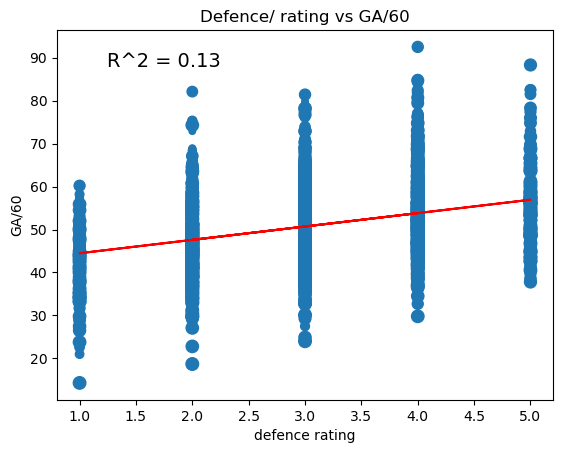

In [274]:
ratings, stats = get_rating_stat_pair('D', ['DZoneStartPerc', 'GP'])

plt.scatter(ratings, list(map(lambda x: x[0], stats)), s=list(map(lambda x: x[1], stats)))

slope, intercept = np.polyfit(ratings, list(map(lambda x: x[0], stats)), 1)
line_of_best_fit = slope * np.array(ratings) + intercept
plt.plot(ratings, line_of_best_fit, 'r', label='y={:.2f}x+{:.2f}'.format(slope, intercept))

slope, intercept, r_value, p_value, std_err = linregress(ratings, list(map(lambda x: x[0], stats)))

r_squared = r_value ** 2

plt.text(0.1, 0.9, f'R^2 = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=14)

plt.xlabel('defence rating')
plt.ylabel('GA/60')
plt.title('Defence/ rating vs GA/60')



Text(0.5, 1.0, 'Defence/ rating vs ATOI/60')

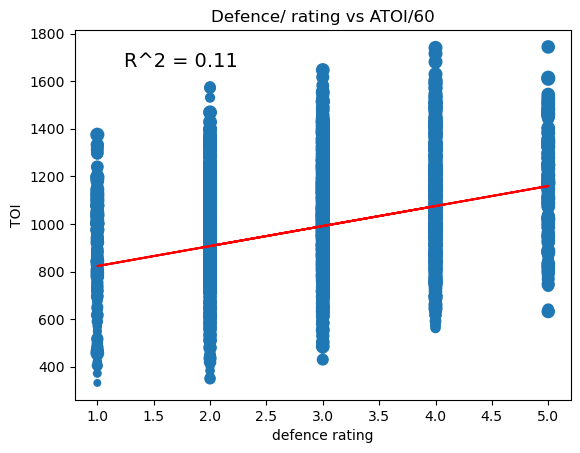

In [275]:
ratings, stats = get_rating_stat_pair('D', ['ATOI', 'GP'])


plt.scatter(ratings, list(map(lambda x: x[0], stats)), s=list(map(lambda x: x[1], stats)))

slope, intercept = np.polyfit(ratings, list(map(lambda x: x[0], stats)), 1)
line_of_best_fit = slope * np.array(ratings) + intercept
plt.plot(ratings, line_of_best_fit, 'r', label='y={:.2f}x+{:.2f}'.format(slope, intercept))

slope, intercept, r_value, p_value, std_err = linregress(ratings, list(map(lambda x: x[0], stats)))

r_squared = r_value ** 2

plt.text(0.1, 0.9, f'R^2 = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=14)

plt.xlabel('defence rating')
plt.ylabel('TOI')
plt.title('Defence/ rating vs ATOI/60')

Text(0.5, 1.0, 'Defence/ rating vs CORSI')

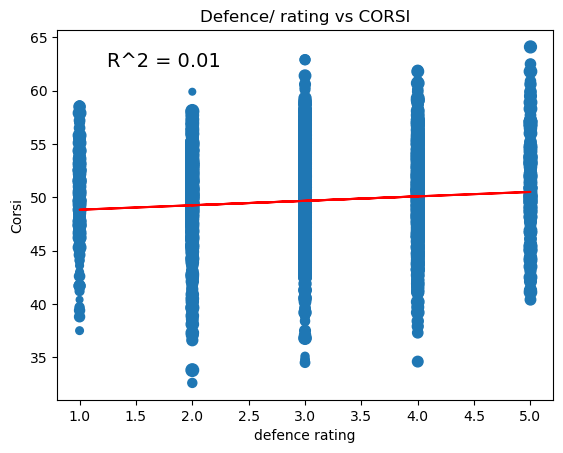

In [276]:
ratings, stats = get_rating_stat_pair('D', ['CorsiForPerc', 'GP'])


plt.scatter(ratings, list(map(lambda x: x[0], stats)), s=list(map(lambda x: x[1], stats)))

slope, intercept = np.polyfit(ratings, list(map(lambda x: x[0], stats)), 1)
line_of_best_fit = slope * np.array(ratings) + intercept
plt.plot(ratings, line_of_best_fit, 'r', label='y={:.2f}x+{:.2f}'.format(slope, intercept))

slope, intercept, r_value, p_value, std_err = linregress(ratings, list(map(lambda x: x[0], stats)))

r_squared = r_value ** 2

plt.text(0.1, 0.9, f'R^2 = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=14)

plt.xlabel('defence rating')
plt.ylabel('Corsi')
plt.title('Defence/ rating vs CORSI')

Text(0.5, 1.0, 'Defence/ rating vs GA/60')

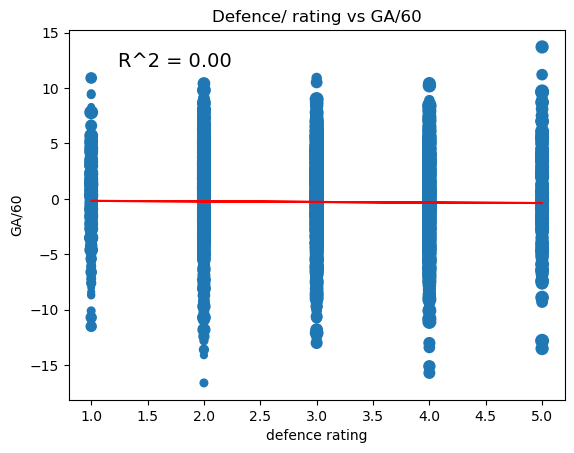

In [277]:
ratings, stats = get_rating_stat_pair('D', ['CorsiForPercRel', 'GP'])


plt.scatter(ratings, list(map(lambda x: x[0], stats)), s=list(map(lambda x: x[1], stats)))

slope, intercept = np.polyfit(ratings, list(map(lambda x: x[0], stats)), 1)
line_of_best_fit = slope * np.array(ratings) + intercept
plt.plot(ratings, line_of_best_fit, 'r', label='y={:.2f}x+{:.2f}'.format(slope, intercept))

slope, intercept, r_value, p_value, std_err = linregress(ratings, list(map(lambda x: x[0], stats)))

r_squared = r_value ** 2

plt.text(0.1, 0.9, f'R^2 = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=14)

plt.xlabel('defence rating')
plt.ylabel('GA/60')
plt.title('Defence/ rating vs GA/60')

Text(0.5, 1.0, 'Defence/ rating vs GA/60')

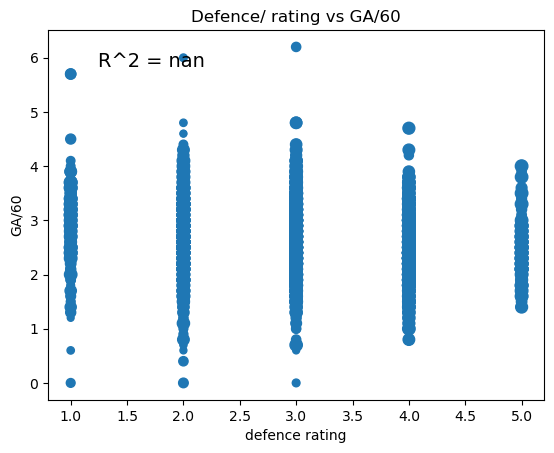

In [278]:
ratings, stats = get_rating_stat_pair('D', ['GAPer60', 'GP'])


plt.scatter(ratings, list(map(lambda x: x[0], stats)), s=list(map(lambda x: x[1], stats)))

slope, intercept = np.polyfit(ratings, list(map(lambda x: x[0], stats)), 1)
line_of_best_fit = slope * np.array(ratings) + intercept
plt.plot(ratings, line_of_best_fit, 'r', label='y={:.2f}x+{:.2f}'.format(slope, intercept))

slope, intercept, r_value, p_value, std_err = linregress(ratings, list(map(lambda x: x[0], stats)))

r_squared = r_value ** 2

plt.text(0.1, 0.9, f'R^2 = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=14)

plt.xlabel('defence rating')
plt.ylabel('GA/60')
plt.title('Defence/ rating vs GA/60')

# Now we will see how our model preforms

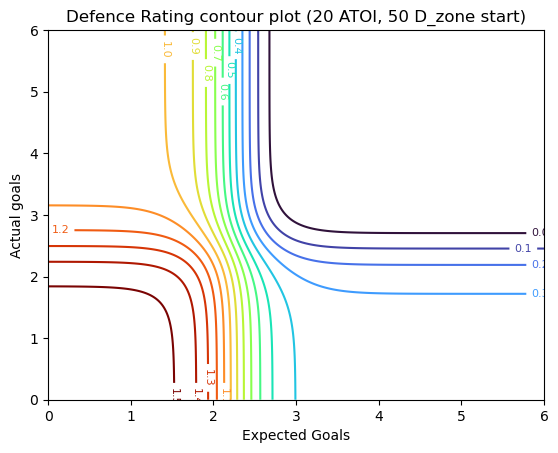

In [279]:
eG_60 = np.linspace(0, 6, 1000)
G_60 = np.linspace(0, 6, 1000)

E, A = np.meshgrid(eG_60, G_60)
RATING = rp.ci_defense_rating(24 * 60, A, 2.5, E, 2.5, 48, 50, 'LD', 0)

contour_plot = plt.contour(E, A, RATING, np.arange(0, 1.6, 0.1), cmap='turbo')

plt.clabel(contour_plot, inline=True, fontsize=8)

plt.xlabel('Expected Goals')
plt.ylabel('Actual goals')
plt.title('Defence Rating contour plot (20 ATOI, 50 D_zone start)')

plt.show()



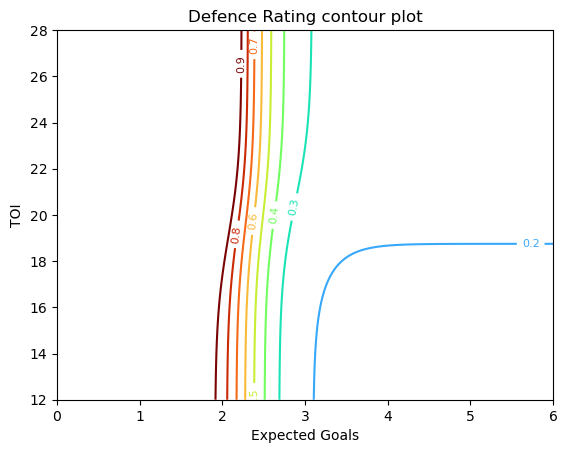

In [280]:
eG_60 = np.linspace(0, 6, 1000)
TOI = np.linspace(12, 28, 1000)

E, A = np.meshgrid(eG_60, TOI)
RATING = rp.ci_defense_rating(A * 60, 2.0, 2.5, E, 2.5, 48, 50, 'LD', 0)

contour_plot = plt.contour(E, A, RATING, np.arange(0, 1, 0.1), cmap='turbo')

plt.clabel(contour_plot, inline=True, fontsize=8)

plt.xlabel('Expected Goals')
plt.ylabel('TOI')
plt.title('Defence Rating contour plot')

plt.show()

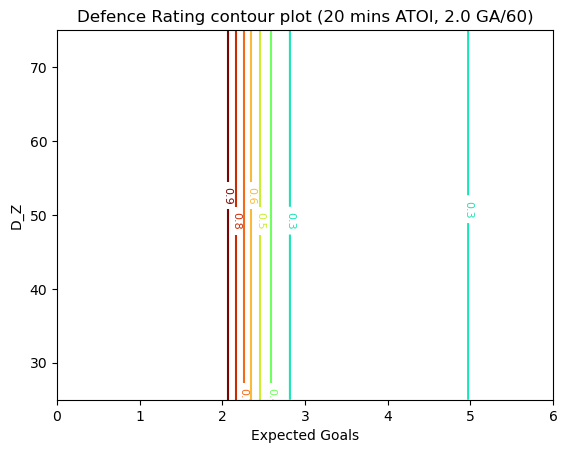

In [281]:
eG_60 = np.linspace(0, 6, 1000)
D_Z = np.linspace(25, 75, 1000)

E, A = np.meshgrid(eG_60, D_Z)
RATING = rp.ci_defense_rating(20 * 60, 2.0, 2.5, E, 2.5, 48, D_Z, 'LD', 0)

contour_plot = plt.contour(E, A, RATING, np.arange(0, 1, 0.1), cmap='turbo')

plt.clabel(contour_plot, inline=True, fontsize=8)

plt.xlabel('Expected Goals')
plt.ylabel('D_Z')
plt.title('Defence Rating contour plot (20 mins ATOI, 2.0 GA/60)')

plt.show()

In [282]:
small

,Player,season,Pos,GP,ATOI,BLK,CorsiForPerc,FenwickPerc,CorsiForPercRel,FenwickPercRel,CorsiAgainst,DZoneStartPerc,GAPer60,XGA,XGF,GFPer60,exGA_60,exGF60,BLK_60,CorsiAgainst_60
0,Justin Abdelkader,14-15,LW,71,1075,28.0,56.4,55.3,4.0,4.1,704,36.4,2.3,29.3,39.1,2.9,1.381985,1.844219,1.320668,33.205372
3,Craig Adams,14-15,RW,70,585,29.0,47.8,47.9,-6.3,-6.6,396,50.0,1.6,18.0,14.6,1.3,1.582418,1.283516,2.549451,34.813187
9,Karl Alzner,14-15,D,82,1166,165.0,50.7,50.6,-0.9,-1.4,1204,50.5,1.8,48.3,53.0,2.3,1.818600,1.995565,6.212609,45.333222
11,Joakim Andersson,14-15,C,68,698,24.0,43.8,44.2,-11.8,-9.8,556,61.2,2.0,26.4,17.8,1.4,2.002360,1.350076,1.820327,42.170908
15,Artem Anisimov,14-15,C,52,983,26.0,50.9,50.6,3.2,3.0,586,55.3,3.4,29.1,27.4,2.7,2.049456,1.929728,1.831129,41.270835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8207,Fabian Zetterlund,22-23,W,67,795,20.0,51.4,50.5,0.1,-1.1,788,50.8,2.2,33.6,32.9,2.8,2.270910,2.223599,1.351732,53.258237
8208,Mika Zibanejad,22-23,C,82,1198,48.0,51.4,52.3,1.9,2.6,1064,51.5,2.1,49.4,51.0,3.3,1.810334,1.868969,1.759029,38.991816
8210,Artem Zub,22-23,D,53,1215,67.0,49.9,51.2,-3.0,-2.1,895,55.2,2.4,39.0,38.1,2.4,2.180294,2.129979,3.745632,50.034941
8211,Mats Zuccarello,22-23,LW,78,1212,51.0,53.0,53.3,4.8,4.5,1145,35.1,2.7,48.0,52.7,2.6,1.827875,2.006855,1.942117,43.602437


In [283]:
small.loc[:, 'GAPer60']

0       2.3
3       1.6
9       1.8
11      2.0
15      3.4
       ... 
8207    2.2
8208    2.1
8210    2.4
8211    2.7
8212    3.2
Name: GAPer60, Length: 6064, dtype: float64

In [284]:
small.loc[:, 'Defence_Rating'] = rp.ci_defense_rating(small[ 'ATOI'].values, small['GAPer60'].values, small['GFPer60'].values, small['exGA_60'].values, small['exGF60'].values,small['CorsiAgainst_60'],small['DZoneStartPerc'].values, small['Pos'].values, small['CorsiForPercRel'].values)

/var/folders/vj/vb8pc7w56j1f0g_fxnwt5pzh0000gn/T/ipykernel_33933/2828527126.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [285]:
small

,Player,season,Pos,GP,ATOI,BLK,CorsiForPerc,FenwickPerc,CorsiForPercRel,FenwickPercRel,...,DZoneStartPerc,GAPer60,XGA,XGF,GFPer60,exGA_60,exGF60,BLK_60,CorsiAgainst_60,Defence_Rating
0,Justin Abdelkader,14-15,LW,71,1075,28.0,56.4,55.3,4.0,4.1,...,36.4,2.3,29.3,39.1,2.9,1.381985,1.844219,1.320668,33.205372,1.455920
3,Craig Adams,14-15,RW,70,585,29.0,47.8,47.9,-6.3,-6.6,...,50.0,1.6,18.0,14.6,1.3,1.582418,1.283516,2.549451,34.813187,1.422411
9,Karl Alzner,14-15,D,82,1166,165.0,50.7,50.6,-0.9,-1.4,...,50.5,1.8,48.3,53.0,2.3,1.818600,1.995565,6.212609,45.333222,1.186872
11,Joakim Andersson,14-15,C,68,698,24.0,43.8,44.2,-11.8,-9.8,...,61.2,2.0,26.4,17.8,1.4,2.002360,1.350076,1.820327,42.170908,1.157173
15,Artem Anisimov,14-15,C,52,983,26.0,50.9,50.6,3.2,3.0,...,55.3,3.4,29.1,27.4,2.7,2.049456,1.929728,1.831129,41.270835,0.877298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8207,Fabian Zetterlund,22-23,W,67,795,20.0,51.4,50.5,0.1,-1.1,...,50.8,2.2,33.6,32.9,2.8,2.270910,2.223599,1.351732,53.258237,0.636718
8208,Mika Zibanejad,22-23,C,82,1198,48.0,51.4,52.3,1.9,2.6,...,51.5,2.1,49.4,51.0,3.3,1.810334,1.868969,1.759029,38.991816,1.433050
8210,Artem Zub,22-23,D,53,1215,67.0,49.9,51.2,-3.0,-2.1,...,55.2,2.4,39.0,38.1,2.4,2.180294,2.129979,3.745632,50.034941,0.708159
8211,Mats Zuccarello,22-23,LW,78,1212,51.0,53.0,53.3,4.8,4.5,...,35.1,2.7,48.0,52.7,2.6,1.827875,2.006855,1.942117,43.602437,1.058301


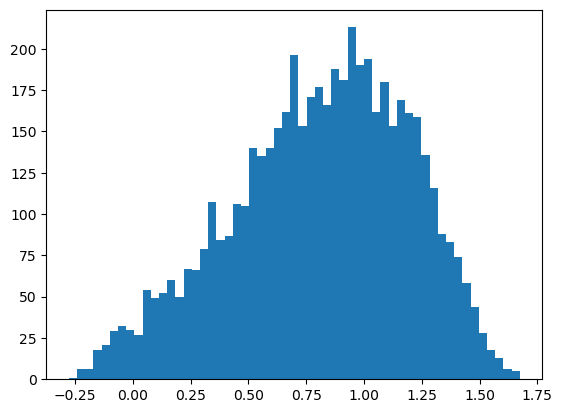

In [286]:
dv.data_histogram(small, 'Defence_Rating', 55)

In [287]:
value_hist = apba['D'].value_counts().sort_index()

value_hist = value_hist.values
value_hist = value_hist[1:]

In [288]:
value_hist


array([ 642, 2636, 2735, 1458,  265])

In [289]:
small = small[small['Defence_Rating'] > 0]
small = small[small['season'] == '20-21']
small['Defence_Rating'] = np.array(small['Defence_Rating']).astype(float)

percentiles = value_hist.cumsum() / value_hist.sum()
thresholds = np.percentile(small['Defence_Rating'], percentiles * 100)

small


,Player,season,Pos,GP,ATOI,BLK,CorsiForPerc,FenwickPerc,CorsiForPercRel,FenwickPercRel,...,DZoneStartPerc,GAPer60,XGA,XGF,GFPer60,exGA_60,exGF60,BLK_60,CorsiAgainst_60,Defence_Rating
5348,Noel Acciari,20-21,C,41,924,63.0,47.6,48.0,-7.2,-7.0,...,68.4,2.3,20.0,23.1,2.0,1.900538,2.195122,5.986696,45.042762,1.172204
5353,Sebastian Aho,20-21,F,56,1168,25.0,56.5,56.3,4.0,4.2,...,43.9,2.4,30.4,36.6,3.5,1.673190,2.014432,1.375978,36.711106,1.357593
5359,Michael Amadio,20-21,C,25,753,16.0,46.8,46.2,-0.1,-1.3,...,44.0,2.8,14.3,10.3,1.4,2.734661,1.969721,3.059761,51.442231,0.062555
5361,Josh Anderson,20-21,RW,52,985,25.0,51.7,51.0,-2.6,-2.4,...,44.0,2.9,25.7,27.8,2.2,1.806326,1.953924,1.757126,43.998438,0.958618
5362,Michael Anderson,20-21,D,54,1271,74.0,48.1,47.9,0.9,0.1,...,53.2,2.1,38.3,37.4,2.1,2.008917,1.961710,3.881458,44.531865,1.156962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6254,Trevor Zegras,20-21,C,24,924,4.0,54.1,51.5,5.3,3.1,...,37.3,2.5,10.2,12.4,3.8,1.655844,2.012987,0.649351,38.474026,1.223739
6255,Mika Zibanejad,20-21,C,56,1206,44.0,45.6,45.5,-1.7,-2.5,...,49.4,3.3,30.9,26.1,3.0,1.647122,1.391258,2.345416,38.805970,1.070507
6257,Artem Zub,20-21,D,47,1103,70.0,49.0,49.7,1.0,1.9,...,63.1,3.0,28.4,26.7,3.3,1.972184,1.854131,4.861017,47.012982,0.756086
6258,Mats Zuccarello,20-21,LW,42,1001,19.0,49.4,49.7,4.5,3.7,...,42.1,2.4,22.1,22.8,3.3,1.892393,1.952333,1.626944,46.153846,1.071059


In [290]:
thresholds = thresholds[:-1]

In [298]:
thresholds = np.insert(thresholds, 0, 0)
binarized = np.digitize(small['Defence_Rating'], thresholds, right=True)

print(thresholds)

[0.         0.         0.35506031 0.88829286 1.22328376 1.49477106]


In [292]:
small['Defence_Rating'] = binarized

In [293]:
small['Defence_Rating'].describe()

count    618.000000
mean       2.750809
std        0.972577
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: Defence_Rating, dtype: float64

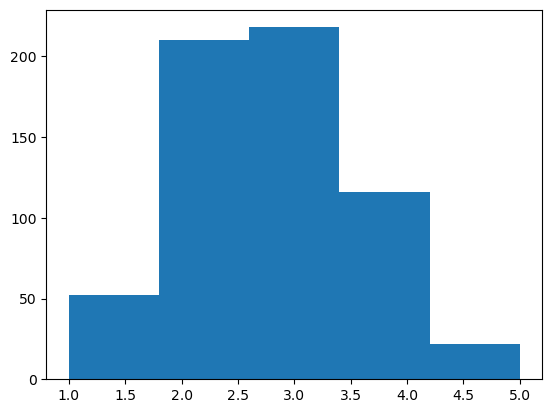

In [294]:
dv.data_histogram(small, 'Defence_Rating', 5)

In [295]:
small

,Player,season,Pos,GP,ATOI,BLK,CorsiForPerc,FenwickPerc,CorsiForPercRel,FenwickPercRel,...,DZoneStartPerc,GAPer60,XGA,XGF,GFPer60,exGA_60,exGF60,BLK_60,CorsiAgainst_60,Defence_Rating
5348,Noel Acciari,20-21,C,41,924,63.0,47.6,48.0,-7.2,-7.0,...,68.4,2.3,20.0,23.1,2.0,1.900538,2.195122,5.986696,45.042762,3
5353,Sebastian Aho,20-21,F,56,1168,25.0,56.5,56.3,4.0,4.2,...,43.9,2.4,30.4,36.6,3.5,1.673190,2.014432,1.375978,36.711106,4
5359,Michael Amadio,20-21,C,25,753,16.0,46.8,46.2,-0.1,-1.3,...,44.0,2.8,14.3,10.3,1.4,2.734661,1.969721,3.059761,51.442231,1
5361,Josh Anderson,20-21,RW,52,985,25.0,51.7,51.0,-2.6,-2.4,...,44.0,2.9,25.7,27.8,2.2,1.806326,1.953924,1.757126,43.998438,3
5362,Michael Anderson,20-21,D,54,1271,74.0,48.1,47.9,0.9,0.1,...,53.2,2.1,38.3,37.4,2.1,2.008917,1.961710,3.881458,44.531865,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6254,Trevor Zegras,20-21,C,24,924,4.0,54.1,51.5,5.3,3.1,...,37.3,2.5,10.2,12.4,3.8,1.655844,2.012987,0.649351,38.474026,4
6255,Mika Zibanejad,20-21,C,56,1206,44.0,45.6,45.5,-1.7,-2.5,...,49.4,3.3,30.9,26.1,3.0,1.647122,1.391258,2.345416,38.805970,3
6257,Artem Zub,20-21,D,47,1103,70.0,49.0,49.7,1.0,1.9,...,63.1,3.0,28.4,26.7,3.3,1.972184,1.854131,4.861017,47.012982,2
6258,Mats Zuccarello,20-21,LW,42,1001,19.0,49.4,49.7,4.5,3.7,...,42.1,2.4,22.1,22.8,3.3,1.892393,1.952333,1.626944,46.153846,3


In [296]:
apba

,Last,First,year,RateAssist,RateCDefence,RateClearing,RateCoincidentalMinor,RateCRank,RateCShotPct,RateCShotPlus,...,RateRWShotPct,RateRWShotPlus,RateSDefence,RateShiftFatigue,RateShotBlocking,RateSkating,RateSpeed,RateSShotPct,RateSShotPlus,D
0,Aho,Sebastian,19,126,4,0,0,1,25,43,...,0,0,0,90,0,5,5,25,43,4
1,Jos. Anderson,Josh,19,44,0,0,0,NaN,0,0,...,23,53,0,90,0,4,4,23,53,5
2,Jo. Bailey,Josh,19,165,0,0,1,NaN,0,0,...,25,33,0,90,0,4,3,25,33,3
3,Barkov,Aleksander,19,112,4,0,1,1,34,59,...,0,0,0,90,0,4,4,34,59,4
4,Barzal,Mathew,19,153,2,0,1,1,20,28,...,0,0,0,90,0,5,5,20,28,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8498,Omark,Linus,14,51,0,0,1,NaN,0,0,...,0,0,0,90,0,3,3,0,3,1
8499,C.Brown,Chris,14,74,1,0,1,3.0,25,33,...,25,33,0,90,0,2,3,25,33,1
8500,Vanek,Thomas,14,139,0,0,1,NaN,0,0,...,22,36,0,90,0,3,3,22,36,2
8501,Moulson,Matt,14,97,0,0,1,NaN,0,0,...,0,0,0,90,0,3,3,26,38,3


In [297]:
tester = abpa[abpa['year'] == '21']
tester


,Last,First,year,RateAssist,RateCDefence,RateClearing,RateCoincidentalMinor,RateCRank,RateCShotPct,RateCShotPlus,...,RateRWShotPct,RateRWShotPlus,RateSDefence,RateShiftFatigue,RateShotBlocking,RateSkating,RateSpeed,RateSShotPct,RateSShotPlus,D
3516,Chara,Zdeno,21,5,0,5,0,,0,0,...,0,0,0,120,1,1,1,6,22,4
3517,Thornton,Joe,21,108,2,0,0,2,24,52,...,0,0,0,90,0,2,1,24,52,2
3518,Marleau,Patrick,21,0,2,0,0,1,15,25,...,15,25,0,90,0,3,3,15,25,2
3519,Spezza,Jason,21,999,2,0,0,2,25,50,...,25,50,0,90,0,3,2,25,50,2
3520,Filppula,Valtteri,21,64,3,0,0,1,48,255,...,48,255,0,90,0,3,3,48,255,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4317,Zub,Artem,21,44,0,3,0,,0,0,...,0,0,0,120,1,3,2,15,57,4
4318,Lehtonen,Mikko,21,41,0,2,0,,0,0,...,0,0,0,120,0,3,3,0,4,3
4319,Lehtonen,Mikko,21,544,0,2,0,,0,0,...,0,0,0,120,0,3,3,0,4,3
4320,Handemark,Fredrik,21,0,1,0,0,1,40,159,...,0,0,0,90,0,1,2,40,159,1


In [300]:
rp.ci_defense_rating(16 * 60 + 32, 2.7, 2.4, 37.3 / 1025.8 * 60 , 34.7 / 1025.8 * 60, 58.6, 61, 'C', 3.8)

0.7050290094874178